# Exercise03 : Just Train in Your Working Machine

Before running on Azure Machine Learning, train example script and create a model as usual in your local compute.<br>
In this exercise, we don't use Azure Machine Learning and just run sample code locally using TensorFlow 1.x.

*back to [index](https://github.com/tsmatz/azureml-tutorial/)*

Show top 3 images in test.tfrecords.

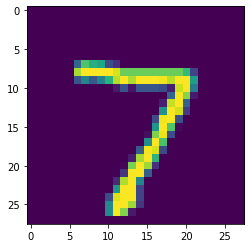

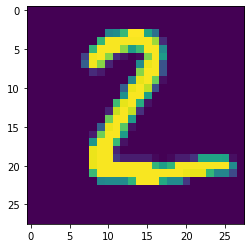

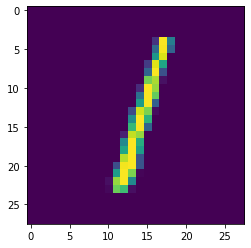

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf

tfdata = tf.data.TFRecordDataset('./data/test.tfrecords')
iterator = tf.compat.v1.data.make_one_shot_iterator(tfdata)
data_org = iterator.get_next()
data_exam = tf.parse_single_example(
    data_org,
    features={
        'image_raw': tf.FixedLenFeature([], tf.string),
        'label': tf.FixedLenFeature([], tf.int64)
    })
data_image = tf.decode_raw(data_exam['image_raw'], tf.uint8)
data_image = tf.reshape(data_image, [28, 28])

# Run tensor and get top 3 images
with tf.Session() as sess:
    for i in range(3):
        image = sess.run([data_image])
        plt.imshow(image[0])
        plt.show()

Train your model in local.<br>
This code (exact same code) will be used in the following exercises with AML.

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sys
import os
import shutil
import argparse
import math

import tensorflow as tf

FLAGS = None
batch_size = 100

#
# define functions for Estimator
#

def _my_input_fn(filepath, num_epochs):
    # image - 784 (=28 x 28) elements of grey-scaled integer value [0, 1]
    # label - digit (0, 1, ..., 9)
    data_queue = tf.train.string_input_producer(
        [filepath],
        num_epochs = num_epochs) # data is repeated and it raises OutOfRange when data is over
    data_reader = tf.TFRecordReader()
    _, serialized_exam = data_reader.read(data_queue)
    data_exam = tf.parse_single_example(
        serialized_exam,
        features={
            'image_raw': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64)
        })
    data_image = tf.decode_raw(data_exam['image_raw'], tf.uint8)
    data_image.set_shape([784])
    data_image = tf.cast(data_image, tf.float32) * (1. / 255)
    data_label = tf.cast(data_exam['label'], tf.int32)
    data_batch_image, data_batch_label = tf.train.batch(
        [data_image, data_label],
        batch_size=batch_size)
    return {'inputs': data_batch_image}, data_batch_label

def _get_input_fn(filepath, num_epochs):
    return lambda: _my_input_fn(filepath, num_epochs)

def _my_model_fn(features, labels, mode):
    # with tf.device(...): # You can set device if using GPUs

    # define network and inference
    # (simple 2 fully connected hidden layer : 784->128->64->10)
    with tf.name_scope('hidden1'):
        weights = tf.Variable(
            tf.truncated_normal(
                [784, FLAGS.first_layer],
                stddev=1.0 / math.sqrt(float(784))),
            name='weights')
        biases = tf.Variable(
            tf.zeros([FLAGS.first_layer]),
            name='biases')
        hidden1 = tf.nn.relu(tf.matmul(features['inputs'], weights) + biases)
    with tf.name_scope('hidden2'):
        weights = tf.Variable(
            tf.truncated_normal(
                [FLAGS.first_layer, FLAGS.second_layer],
                stddev=1.0 / math.sqrt(float(FLAGS.first_layer))),
            name='weights')
        biases = tf.Variable(
            tf.zeros([FLAGS.second_layer]),
            name='biases')
        hidden2 = tf.nn.relu(tf.matmul(hidden1, weights) + biases)
    with tf.name_scope('softmax_linear'):
        weights = tf.Variable(
            tf.truncated_normal(
                [FLAGS.second_layer, 10],
                stddev=1.0 / math.sqrt(float(FLAGS.second_layer))),
        name='weights')
        biases = tf.Variable(
            tf.zeros([10]),
            name='biases')
        logits = tf.matmul(hidden2, weights) + biases
 
    # compute evaluation matrix
    predicted_indices = tf.argmax(input=logits, axis=1)
    if mode != tf.estimator.ModeKeys.PREDICT:
        label_indices = tf.cast(labels, tf.int32)
        accuracy = tf.metrics.accuracy(label_indices, predicted_indices)
        tf.summary.scalar('accuracy', accuracy[1]) # output to TensorBoard
 
        loss = tf.losses.sparse_softmax_cross_entropy(
            labels=labels,
            logits=logits)
 
    # define operations
    if mode == tf.estimator.ModeKeys.TRAIN:
        #global_step = tf.train.create_global_step()
        #global_step = tf.contrib.framework.get_or_create_global_step()
        global_step = tf.train.get_or_create_global_step()        
        optimizer = tf.train.GradientDescentOptimizer(
            learning_rate=FLAGS.learning_rate)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=global_step)
        return tf.estimator.EstimatorSpec(
            mode,
            loss=loss,
            train_op=train_op)
    if mode == tf.estimator.ModeKeys.EVAL:
        eval_metric_ops = {
            'accuracy': accuracy
        }
        return tf.estimator.EstimatorSpec(
            mode,
            loss=loss,
            eval_metric_ops=eval_metric_ops)
    if mode == tf.estimator.ModeKeys.PREDICT:
        probabilities = tf.nn.softmax(logits, name='softmax_tensor')
        predictions = {
            'classes': predicted_indices,
            'probabilities': probabilities
        }
        export_outputs = {
            'prediction': tf.estimator.export.PredictOutput(predictions)
        }
        return tf.estimator.EstimatorSpec(
            mode,
            predictions=predictions,
            export_outputs=export_outputs)

def _my_serving_input_fn():
    inputs = {'inputs': tf.placeholder(tf.float32, [None, 784])}
    return tf.estimator.export.ServingInputReceiver(inputs, inputs)

#
# Main
#

parser = argparse.ArgumentParser()
parser.add_argument(
    '--data_folder',
    type=str,
    default='./data',
    help='Folder path for input data')
parser.add_argument(
    '--chkpoint_folder',
    type=str,
    default='./logs',  # AML experiments logs folder
    help='Folder path for checkpoint files')
parser.add_argument(
    '--model_folder',
    type=str,
    default='./outputs',  # AML experiments outputs folder
    help='Folder path for model output')
parser.add_argument(
    '--learning_rate',
    type=float,
    default='0.07',
    help='Learning Rate')
parser.add_argument(
    '--first_layer',
    type=int,
    default='128',
    help='Neuron number for the first hidden layer')
parser.add_argument(
    '--second_layer',
    type=int,
    default='64',
    help='Neuron number for the second hidden layer')
FLAGS, unparsed = parser.parse_known_args()

# clean checkpoint and model folder if exists
if os.path.exists(FLAGS.chkpoint_folder) :
    for file_name in os.listdir(FLAGS.chkpoint_folder):
        file_path = os.path.join(FLAGS.chkpoint_folder, file_name)
        if os.path.isfile(file_path):
            os.remove(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
if os.path.exists(FLAGS.model_folder) :
    for file_name in os.listdir(FLAGS.model_folder):
        file_path = os.path.join(FLAGS.model_folder, file_name)
        if os.path.isfile(file_path):
            os.remove(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)

# read TF_CONFIG
run_config = tf.estimator.RunConfig()

# create Estimator
mnist_fullyconnected_classifier = tf.estimator.Estimator(
    model_fn=_my_model_fn,
    model_dir=FLAGS.chkpoint_folder,
    config=run_config)
train_spec = tf.estimator.TrainSpec(
    input_fn=_get_input_fn(os.path.join(FLAGS.data_folder, 'train.tfrecords'), 2),
    max_steps=60000 * 2 / batch_size)
eval_spec = tf.estimator.EvalSpec(
    input_fn=_get_input_fn(os.path.join(FLAGS.data_folder, 'test.tfrecords'), 1),
    steps=10000 * 1 / batch_size,
    start_delay_secs=0)

# run !
tf.estimator.train_and_evaluate(
    mnist_fullyconnected_classifier,
    train_spec,
    eval_spec
)

# save model and variables
model_dir = mnist_fullyconnected_classifier.export_savedmodel(
    export_dir_base = FLAGS.model_folder,
    serving_input_receiver_fn = _my_serving_input_fn)
print('current working directory is ', os.getcwd())
print('model is saved ', model_dir)

INFO:tensorflow:Using config: {'_model_dir': './logs', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4ea0021748>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locall

INFO:tensorflow:Done calling model_fn.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['prediction', 'serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from ./logs/model.ckpt-1100
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./outputs/temp-b'1645683081'/saved_model.pb
current working directory is  /home/tsmatsuz/cli_yaml
model is saved  b'./outputs/1645683081'


Predict using generated model. This code will be used in "[Exercise08 : Publish as a Web Service](./exercise08_publish_model.ipynb)".

In [3]:
import tensorflow as tf

# Read data by tensor
tfdata = tf.data.TFRecordDataset('./data/test.tfrecords')
iterator = tf.compat.v1.data.make_one_shot_iterator(tfdata)
data_org = iterator.get_next()
data_exam = tf.parse_single_example(
    data_org,
    features={
        'image_raw': tf.FixedLenFeature([], tf.string),
        'label': tf.FixedLenFeature([], tf.int64)
    })
data_image = tf.decode_raw(data_exam['image_raw'], tf.uint8)
data_image.set_shape([784])
data_image = tf.cast(data_image, tf.float32) * (1. / 255)
data_label = tf.cast(data_exam['label'], tf.int32)

# Run tensor and get top 3 data
with tf.Session() as sess:
    image_arr = []
    label_arr = []
    for i in range(3):
        image, label = sess.run([data_image, data_label])
        image_arr.append(image)
        label_arr.append(label)

# Predict
pred_fn = tf.contrib.predictor.from_saved_model(model_dir)
pred = pred_fn({'inputs': image_arr})

print('Predicted: ', pred['classes'].tolist())
print('Actual   : ', label_arr)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from ./outputs/1645683081/variables/variables
Predicted:  [7, 2, 1]
Actual   :  [7, 2, 1]
